In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/animal shelter LB/animal-shelter-intakes-and-outcomes (1).csv')
print(data.head())

  Animal ID            Animal Name Animal Type Primary Color Secondary Color  \
0   A664584  *OLD ENDLISH GAME HEN        BIRD         BROWN             RED   
1   A632112                 *PATSY         CAT         BLACK             NaN   
2   A613531                    NaN         DOG         WHITE             NaN   
3   A626772                 BOOGIE         DOG         BROWN            GRAY   
4   A626773                   GIGI         DOG         BLACK             NaN   

       Sex         DOB Intake Date Intake Condition      Intake Type  ...  \
0   Female         NaN  2021-09-28           NORMAL            STRAY  ...   
1   Female  2019-06-11  2019-08-17           NORMAL            STRAY  ...   
2     Male  2017-11-23  2018-08-23           NORMAL            STRAY  ...   
3  Unknown  2012-05-22  2019-05-22           NORMAL  OWNER SURRENDER  ...   
4  Unknown  2016-05-22  2019-05-22           NORMAL  OWNER SURRENDER  ...   

                                   Crossing Jurisdiction

In [4]:
print(data.describe())

           latitude     longitude  was_outcome_alive
count  27199.000000  27199.000000       27199.000000
mean      33.814893   -118.147658           0.793522
std        0.152578      0.570708           0.404785
min       19.297815   -121.662622           0.000000
25%       33.784158   -118.190353           1.000000
50%       33.807294   -118.173076           1.000000
75%       33.851168   -118.127996           1.000000
max       40.304278    -73.992360           1.000000


In [5]:
data.info()  # summary of the DataFrame including column names and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27199 entries, 0 to 27198
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Animal ID          27199 non-null  object 
 1   Animal Name        15705 non-null  object 
 2   Animal Type        27199 non-null  object 
 3   Primary Color      27199 non-null  object 
 4   Secondary Color    12936 non-null  object 
 5   Sex                27199 non-null  object 
 6   DOB                23851 non-null  object 
 7   Intake Date        27199 non-null  object 
 8   Intake Condition   27199 non-null  object 
 9   Intake Type        27199 non-null  object 
 10  Intake Subtype     26886 non-null  object 
 11  Reason for Intake  1866 non-null   object 
 12  Outcome Date       27029 non-null  object 
 13  Crossing           27199 non-null  object 
 14  Jurisdiction       27199 non-null  object 
 15  Outcome Type       27027 non-null  object 
 16  Outcome Subtype    239

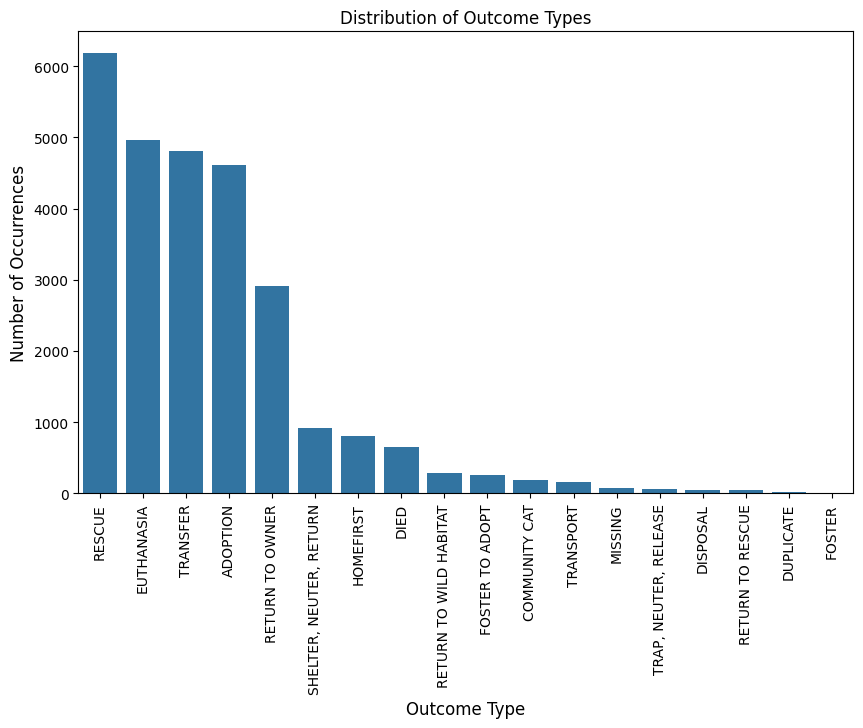

In [6]:
# Visualize the distribution of the target variable 'Outcome Type'
plt.figure(figsize=(10, 6))
outcome_counts = data['Outcome Type'].value_counts()
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Distribution of Outcome Types')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Outcome Type', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [7]:
# Check for any missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)

Animal ID                0
Animal Name          11494
Animal Type              0
Primary Color            0
Secondary Color      14263
Sex                      0
DOB                   3348
Intake Date              0
Intake Condition         0
Intake Type              0
Intake Subtype         313
Reason for Intake    25333
Outcome Date           170
Crossing                 0
Jurisdiction             0
Outcome Type           172
Outcome Subtype       3292
latitude                 0
longitude                0
intake_is_dead           0
outcome_is_dead          0
was_outcome_alive        0
geopoint                 0
dtype: int64


In [8]:
# Convert 'Intake Date' and 'Outcome Date' to datetime and create 'Days in Shelter'
data['Intake Date'] = pd.to_datetime(data['Intake Date'])
data['Outcome Date'] = pd.to_datetime(data['Outcome Date'])
data['Days in Shelter'] = (data['Outcome Date'] - data['Intake Date']).dt.days


In [9]:
# Advanced Feature Engineering: Age at intake
data['DOB'] = pd.to_datetime(data['DOB'])
data['Age at Intake (days)'] = (data['Intake Date'] - data['DOB']).dt.days

In [10]:
# Impute missing values using KNN for numerical columns
knn_imputer = KNNImputer(n_neighbors=5)
data[['Age at Intake (days)']] = knn_imputer.fit_transform(data[['Age at Intake (days)']])
print("Missing values for 'Age at Intake (days)' imputed.")

Missing values for 'Age at Intake (days)' imputed.


In [11]:
# Drop rows where 'Outcome Date' or 'Outcome Type' is missing
data.dropna(subset=['Outcome Date', 'Outcome Type'], inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27027 entries, 0 to 27198
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Animal ID             27027 non-null  object        
 1   Animal Name           15575 non-null  object        
 2   Animal Type           27027 non-null  object        
 3   Primary Color         27027 non-null  object        
 4   Secondary Color       12845 non-null  object        
 5   Sex                   27027 non-null  object        
 6   DOB                   23681 non-null  datetime64[ns]
 7   Intake Date           27027 non-null  datetime64[ns]
 8   Intake Condition      27027 non-null  object        
 9   Intake Type           27027 non-null  object        
 10  Intake Subtype        26725 non-null  object        
 11  Reason for Intake     1851 non-null   object        
 12  Outcome Date          27027 non-null  datetime64[ns]
 13  Crossing             

In [12]:
# Create a target variable 'Adopted Within 30 Days'
data['Adopted Within 30 Days'] = (data['Days in Shelter'] <= 30) & (data['Outcome Type'] == 'ADOPTION').astype(int)


In [13]:
# One-hot encode categorical variables
categorical_columns = ['Animal Type', 'Sex', 'Intake Condition', 'Intake Type']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print(data_encoded.head())


  Animal ID            Animal Name Primary Color Secondary Color        DOB  \
0   A664584  *OLD ENDLISH GAME HEN         BROWN             RED        NaT   
1   A632112                 *PATSY         BLACK             NaN 2019-06-11   
2   A613531                    NaN         WHITE             NaN 2017-11-23   
3   A626772                 BOOGIE         BROWN            GRAY 2012-05-22   
4   A626773                   GIGI         BLACK             NaN 2016-05-22   

  Intake Date Intake Subtype Reason for Intake Outcome Date  \
0  2021-09-28          FIELD               NaN   2021-10-06   
1  2019-08-17            OTC               NaN   2019-08-21   
2  2018-08-23          FIELD               NaN   2018-08-29   
3  2019-05-22            OTC              MOVE   2019-05-23   
4  2019-05-22            OTC              MOVE   2019-05-23   

                                   Crossing  ...  \
0   300 BLK E 63RD ST, LONG BEACH, CA 90802  ...   
1  300 BLK E 67TH ST, LOPNG BEACH, CA 9080

In [14]:
# Feature Scaling
scaler = MinMaxScaler()
data_encoded[['Age at Intake (days)', 'Days in Shelter']] = scaler.fit_transform(data_encoded[['Age at Intake (days)', 'Days in Shelter']])
print("Data after scaling:")
print(data_encoded[['Age at Intake (days)', 'Days in Shelter']].head())


Data after scaling:
   Age at Intake (days)  Days in Shelter
0              0.064241         0.007124
1              0.023086         0.003562
2              0.034146         0.005343
3              0.156716         0.000890
4              0.078278         0.000890


In [15]:
# Select features and target variable for modeling
X = data_encoded.drop(['Animal ID', 'Animal Name', 'Primary Color', 'Secondary Color', 'DOB', 'Intake Date',
                       'Intake Subtype', 'Reason for Intake', 'Outcome Date', 'Crossing', 'Jurisdiction',
                       'Outcome Type', 'Outcome Subtype', 'latitude', 'longitude', 'intake_is_dead',
                       'outcome_is_dead', 'was_outcome_alive', 'geopoint', 'Days in Shelter',
                       'Adopted Within 30 Days'], axis=1)
y = data_encoded['Adopted Within 30 Days'].astype(int)


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training and testing data split successfully.")

Training and testing data split successfully.


In [17]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("SMOTE applied to training data.")


SMOTE applied to training data.


In [18]:
# Initialize the GBM model
gbm_model = GradientBoostingClassifier(random_state=42)


In [19]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: 0.86


In [20]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: 0.86


In [21]:
# Initialize the GBM model with the best parameters
gbm_best = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
gbm_best.fit(X_train, y_train)


GradientBoostingClassifier(max_depth=7, n_estimators=300, random_state=42,
                           subsample=0.8)

In [22]:
# Evaluate the model
y_pred = gbm_best.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8233444321124677
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      4928
           1       0.28      0.65      0.39       478

    accuracy                           0.82      5406
   macro avg       0.62      0.74      0.64      5406
weighted avg       0.90      0.82      0.85      5406



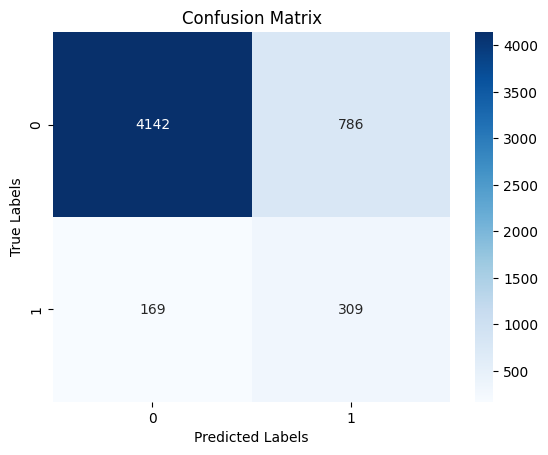

In [23]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

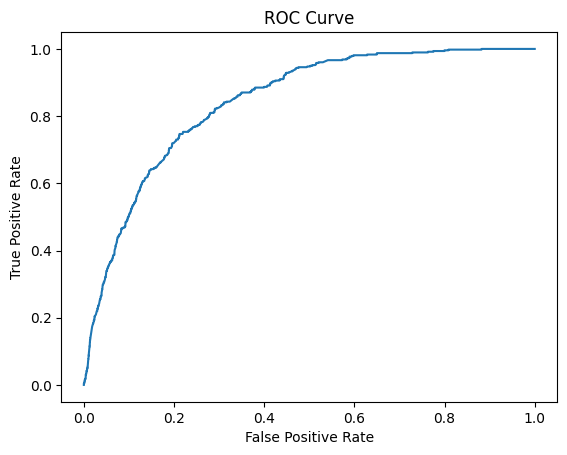

In [24]:
# ROC Curve
y_proba = gbm_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [25]:
# AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", auc_score)

ROC-AUC Score: 0.8428595626392434


In [26]:
# Assuming data_encoded already contains the processed data

# Select features and target variable for modeling
X = data_encoded.drop(['Animal ID', 'Animal Name', 'Primary Color', 'Secondary Color', 'DOB', 'Intake Date',
                       'Intake Subtype', 'Reason for Intake', 'Outcome Date', 'Crossing', 'Jurisdiction',
                       'Outcome Type', 'Outcome Subtype', 'latitude', 'longitude', 'intake_is_dead',
                       'outcome_is_dead', 'was_outcome_alive', 'geopoint', 'Days in Shelter',
                       'Adopted Within 30 Days'], axis=1)

# Now display the features used in the model
print("Features used in the model:", X.columns.tolist())


Features used in the model: ['Age at Intake (days)', 'Animal Type_BIRD', 'Animal Type_CAT', 'Animal Type_DOG', 'Animal Type_GUINEA PIG', 'Animal Type_LIVESTOCK', 'Animal Type_OTHER', 'Animal Type_RABBIT', 'Animal Type_REPTILE', 'Animal Type_WILD', 'Sex_Male', 'Sex_Neutered', 'Sex_Spayed', 'Sex_Unknown', 'Intake Condition_BEHAVIOR  MILD', 'Intake Condition_BEHAVIOR  MODERATE', 'Intake Condition_BEHAVIOR  SEVERE', 'Intake Condition_FERAL', 'Intake Condition_FRACTIOUS', 'Intake Condition_I/I REPORT', 'Intake Condition_ILL MILD', 'Intake Condition_ILL MODERATETE', 'Intake Condition_ILL SEVERE', 'Intake Condition_INJURED  MILD', 'Intake Condition_INJURED  MODERATE', 'Intake Condition_INJURED  SEVERE', 'Intake Condition_NORMAL', 'Intake Condition_UNDER AGE/WEIGHT', 'Intake Condition_WELFARE SEIZURES', 'Intake Type_CONFISCATE', 'Intake Type_Euthenasia Required', 'Intake Type_FOSTER', 'Intake Type_OWNER SURRENDER', 'Intake Type_QUARANTINE', 'Intake Type_RETURN', 'Intake Type_SAFE KEEP', 'Intak

In [27]:
# features and target variable for model
X = data_encoded.drop(['Animal ID', 'Animal Name', 'Primary Color', 'Secondary Color', 'DOB', 'Intake Date',
                       'Intake Subtype', 'Reason for Intake', 'Outcome Date', 'Crossing', 'Jurisdiction',
                       'Outcome Type', 'Outcome Subtype', 'latitude', 'longitude', 'intake_is_dead',
                       'outcome_is_dead', 'was_outcome_alive', 'geopoint', 'Days in Shelter',
                       'Adopted Within 30 Days'], axis=1)

feature_df = pd.DataFrame(X.columns, columns=['Model Features'])

print(feature_df)

                         Model Features
0                  Age at Intake (days)
1                      Animal Type_BIRD
2                       Animal Type_CAT
3                       Animal Type_DOG
4                Animal Type_GUINEA PIG
5                 Animal Type_LIVESTOCK
6                     Animal Type_OTHER
7                    Animal Type_RABBIT
8                   Animal Type_REPTILE
9                      Animal Type_WILD
10                             Sex_Male
11                         Sex_Neutered
12                           Sex_Spayed
13                          Sex_Unknown
14      Intake Condition_BEHAVIOR  MILD
15  Intake Condition_BEHAVIOR  MODERATE
16    Intake Condition_BEHAVIOR  SEVERE
17               Intake Condition_FERAL
18           Intake Condition_FRACTIOUS
19          Intake Condition_I/I REPORT
20            Intake Condition_ILL MILD
21      Intake Condition_ILL MODERATETE
22          Intake Condition_ILL SEVERE
23       Intake Condition_INJURED  MILD
